In [1]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle
import importlib.util
spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py') #Default Windows lumapi path
lumapi = importlib.util.module_from_spec(spec_win) #windows
spec_win.loader.exec_module(lumapi)
sys.path.append(os.path.dirname('C:/Users/moise/Downloads/'))
##"C:\Users\moise\Downloads\MMI 2 X 8 MOISES.lms"

In [2]:
mode = lumapi.MODE(filename= 'MMI_2X8.lms')

In [50]:
BdX_Span = 96e-6 # Body X Span
W = 18e-6 # Body y Span

InP = 2 
OutP = 8 
TLen = 5e-6 
TWidth = 1.5e-6
MeshEnable = 0
SetToTappers = 1
TapperSweep = 1
EME_MC_y = 230 # Number of EME Mesh Cells Y
EME_MC_Z = 230
SideCells = 15 # Number of Cells on Input/Output groups

In [51]:
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })

In [54]:
mode.switchtolayout()
mode.selectall()
mode.delete()


RectInsert(BdX_Span/2,BdX_Span, 0,  W, 0e-6,0.22e-6,
"Si (Silicon) - Palik",mode)
mode.set("name","MMI")

mode.addobject("linear_taper")
mode.set({"first axis":"z", "rotation 1":180,
"angle_side":90,
"x":-TLen/2, "z":0, "len":TLen,
"thickness":0.22e-6,
"width_l":TWidth,
"width_r": 0.45e-6,  
"name":"Input Taper "})
mode.set("y",W/6)

mode.addobject("linear_taper")
mode.set({"first axis":"z", "rotation 1":180,
"angle_side":90,
"x":-TLen/2, "z":0, "len":TLen,
"thickness":0.22e-6,
"width_l":TWidth,
"width_r": 0.45e-6,   
"name":"Input Taper "})
mode.set("y",-W/6)


##input retangulos
RectInsert(-TLen-(2.5e-6),5e-6, W/6,0.45e-6, 0e-6,0.22e-6,
"Si (Silicon) - Palik",mode)
mode.set("name","rect_input_1")

RectInsert(-TLen-(2.5e-6),5e-6, -W/6,0.45e-6, 0e-6,0.22e-6,
"Si (Silicon) - Palik",mode)
mode.set("name","rect_input_2")

W_OUT = 0
## output tapers
if(SetToTappers == 1):
    for i in range(8):
            A = (i+1)%2
            if(A==1):
                W_OUT = W/2 -(W/OutP)*(i+1-(1/3))
            else:
                W_OUT = W/2-(W/OutP)*(i+1-(2/3))
         
            mode.addobject("linear_taper")
            mode.set({"first axis":"z", "rotation 1":180,
                "angle_side":90,
                 "x":BdX_Span + (TLen/2) , "z":0, "len":TLen,
                 "thickness":0.22e-6,
                 "width_l":0.45e-6,
                 "width_r":TWidth,   
                 "name":"Output Taper "+ str(i+1)})
            mode.set("y",W_OUT)
    


#rect outputs
x_out = 0
y_out = 0
for i in range(8):
    if((i+1)%2==1):
        x_out = BdX_Span + TLen + (2.5e-6)
        y_out = W/2-(W/OutP)*(i+1-(1/3))
    else:
        y_out = (W/2)-(W/OutP)*(i+1-(2/3))
    RectInsert(x_out,TLen, y_out,0.45e-6, 0,0.22e-6,"Si (Silicon) - Palik",mode)
    mode.set("name","rect output" + str(i+1))

In [55]:
mode.select("EME")
mode.delete()
mode.addeme()
mode.set("allow custom eigensolver settings",1)
mode.set("display cells",1)
mode.set("number of cell groups",3)
mode.set("group spans", np.transpose([(TLen+5e-6)/2, BdX_Span, (TLen+2.5e-6)]))
mode.set("cells",np.transpose([SideCells, 1, SideCells]))
mode.set("subcell method",np.transpose([1, 0, 1]))# 0 = none,  1 = CVCS
mode.set("modes",np.transpose([20, 80, 20]))

mode.set("x min",(-TLen-5e-6)/2 )
mode.set("y",0)
mode.set("y",0)
mode.set("y span", W +8e-6)
mode.set("z",0)
mode.set("z span",4e-6)

mode.set("y min bc","PML")
mode.set("y max bc","PML")
mode.set("z min bc","Symmetric")
mode.set("z max bc","PML")
mode.set("background material", "SiO2 (Glass) - Palik")
mode.set("mesh cells y",EME_MC_y)
mode.set("mesh cells z",EME_MC_Z)


# EME Ports config
mode.selectpartial("EME::Ports::port")
mode.delete()

#input port

mode.addemeport()
mode.set({"use full simulation span":0,
"port location":"left",
"y":W/6, "y span":4e-6,
"z":0, "z span":4e-6})

Y_OUT = 0

#outputports  
for i in range(8):
    B = (i+1)%2
    mode.addemeport()
    if(B==1):
        Y_OUT = W/2 -(W/OutP)*(i+1-(1/3))
    else:
        Y_OUT = W/2-(W/OutP)*(i+1-(2/3))
    mode.set({"use full simulation span":0,
    "port location":"right",
    "y span":1.45e-6,
    "z":0, "z span":4e-6})
    mode.set("y",Y_OUT)
   


      
# Monitors config
mode.addemeprofile()
mode.set("x", BdX_Span/2)
mode.set("x span", BdX_Span+TLen+10e-6)
mode.set("y",0)
mode.set("y span",W + 8e-6)

##ADDING MESH

mode.addmesh()
mode.set("name","mesh_input")
mode.set({"based on a structure": 1, "structure": "Input Taper " + str(1),
"set mesh multiplier": 1,
"set equivalent index": 1, "override x mesh":1,"override y mesh":1,
"override z mesh":1})
mode.set({"z mesh multiplier":1,"y mesh multiplier":2.5,"x mesh multiplier":2.5})

for k in range (8):
    mode.addmesh()
    mode.set("name","mesh " + str(k+1))
    mode.set({"based on a structure": 1, "structure": "Output Taper " + str(k+1),
    "set mesh multiplier": 1,
    "set equivalent index": 1, "override x mesh":1,"override y mesh":1,
    "override z mesh":1})
    mode.set({"z mesh multiplier":1,"y mesh multiplier":2.5,"x mesh multiplier":2.5})

mode.run()
mode.emepropagate()
res = mode.getresult("EME","user s matrix")
TdB = np.zeros(9)
for k in range(9):
    TdB[k] = 10*np.log10((np.abs(res[k,0]))**2)
print(TdB)

[-46.30728082  -9.12108631  -9.53798203  -8.36251832 -10.33885095
  -8.49874657 -10.40557308  -9.08387675  -9.69205539]


## otimização do mesh

Progress: 1/8
Progress: 2/8
Progress: 3/8
Progress: 4/8
Progress: 5/8
Progress: 6/8
Progress: 7/8
Progress: 8/8


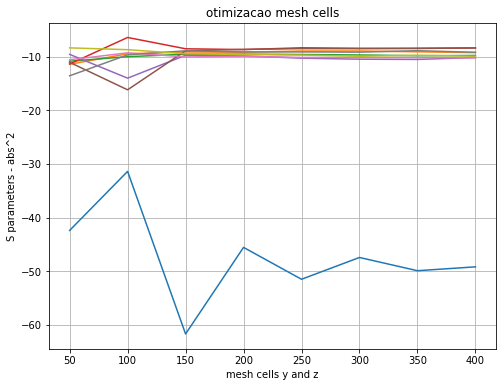

In [12]:
iterations = 8
mesh_y = [50, 400]
mesh = np.linspace(mesh_y[0],mesh_y[1],iterations)

mesh_matrix = np.zeros((iterations, 9))

for j in range(iterations):
    text = "Progress: " + str(j+1) + "/" + str(iterations)
    print(text)  

    mode.switchtolayout()
    mode.select("EME")
    mode.set("mesh cells y",mesh[j])
    mode.set("mesh cells z", mesh[j])

    mode.run()
    mode.emepropagate()

    Result = mode.getresult("EME", "user s matrix")
    for k in range(9):
        mesh_matrix[j,k] = 10*np.log10((np.abs(Result[k,0]))**2)

plt.figure(figsize=(8,6))
plt.plot(mesh,mesh_matrix)
plt.xlabel('mesh cells y and z')
plt.ylabel('S parameters - abs^2')
plt.title('otimizacao mesh cells')
plt.grid(True)


Progress: 1/10
Progress: 2/10
Progress: 3/10
Progress: 4/10
Progress: 5/10
Progress: 6/10
Progress: 7/10
Progress: 8/10
Progress: 9/10
Progress: 10/10


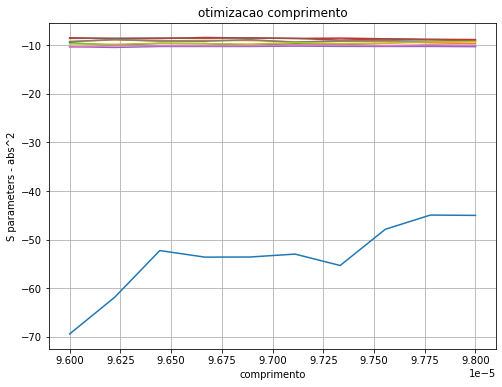

In [18]:
iterations_comprimento = 10
comprimento = [96e-6, 98e-6]
C_matrix = np.linspace(comprimento[0],comprimento[1],iterations_comprimento)

sol_matrix = np.zeros((iterations_comprimento, 9))

for j in range(iterations_comprimento):
    text = "Progress: " + str(j+1) + "/" + str(iterations_comprimento)
    print(text)  

    mode.switchtolayout()
    mode.setnamed("MMI","x",C_matrix[j]/2)
    mode.setnamed("MMI","x span", C_matrix[j])
    for i in range (8):
        mode.select("Output Taper "+ str(i+1))
        mode.set("x",C_matrix[j] + (TLen/2))
        mode.select("rect output"+str(i+1))
        mode.set("x",C_matrix[j] + TLen + (2.5e-6))
        mode.select("monitor")
        mode.set("x",C_matrix[j]/2)
        mode.set("x span",C_matrix[j]+TLen+10e-6)

    mode.select("EME")
    mode.set("mesh cells y",230)
    mode.set("mesh cells z", 230)
    mode.set("group spans", np.transpose([(TLen+5e-6)/2, C_matrix[j], (TLen+2.5e-6)]))

    mode.run()
    mode.emepropagate()

    Result_comprimento = mode.getresult("EME", "user s matrix")

    for k in range(9):
        sol_matrix[j,k] = 10*np.log10((np.abs(Result_comprimento[k,0]))**2)

plt.figure(figsize=(8,6))
plt.plot(C_matrix,sol_matrix)
plt.xlabel('comprimento')
plt.ylabel('S parameters - abs^2')
plt.title('otimizacao comprimento')
plt.grid(True)


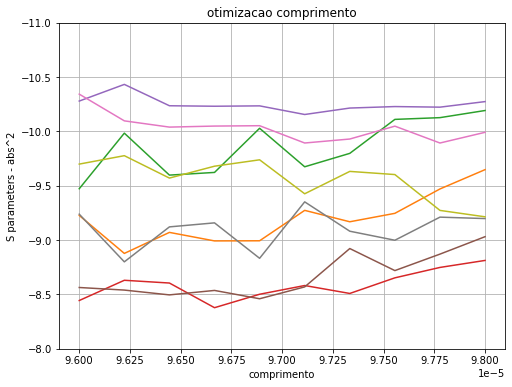

In [25]:
plt.figure(figsize=(8,6))
plt.plot(C_matrix,sol_matrix)
plt.xlabel('comprimento')
plt.ylabel('S parameters - abs^2')
plt.title('otimizacao comprimento')
plt.ylim([-8,-11])
plt.grid(True)

In [22]:
print(C_matrix)
print(  sol_matrix)


[9.60000000e-05 9.62222222e-05 9.64444444e-05 9.66666667e-05
 9.68888889e-05 9.71111111e-05 9.73333333e-05 9.75555556e-05
 9.77777778e-05 9.80000000e-05]
[[-69.43595097  -9.22667743  -9.47228203  -8.44411941 -10.2786744
   -8.56389434 -10.34241385  -9.23837672  -9.69889481]
 [-61.87396903  -8.87734947  -9.98347288  -8.63023686 -10.43192271
   -8.54008891 -10.09659124  -8.79982558  -9.77627569]
 [-52.25977636  -9.07066343  -9.59760676  -8.60494704 -10.2355434
   -8.49584204 -10.03916301  -9.12139747  -9.57032903]
 [-53.61192831  -8.99232195  -9.6222531   -8.37812976 -10.23108489
   -8.53685009 -10.04861158  -9.15834368  -9.67952815]
 [-53.58833946  -8.99349745 -10.02828941  -8.50174729 -10.23449572
   -8.46031657 -10.05201684  -8.83240287  -9.73834007]
 [-52.9879521   -9.27333557  -9.67415471  -8.58206164 -10.15512883
   -8.5694724   -9.89290846  -9.35152263  -9.42591067]
 [-55.3367189   -9.16839143  -9.79761002  -8.50900489 -10.21437527
   -8.92210966  -9.92947807  -9.08158336  -9.6317

In [40]:
number_of_distance_sweeps = 7
move = [2.3e-6,4.5e-6]

dMatrix_1 = np.zeros((number_of_distance_sweeps, 2))
dMatrix_2 = np.zeros((number_of_distance_sweeps, 2))
move_Matrix = np.linspace(move[0],move[1],number_of_distance_sweeps)

if(TapperSweep == 1) :
    for i in range(number_of_distance_sweeps):
        text = "Progress: " + str(i+1) + "/" + str(number_of_distance_sweeps)
        print(text)  
    
        mode.switchtolayout()

        mode.setnamed("Output Taper 3", "y", move_Matrix[i])
        mode.setnamed("rect output3","y", move_Matrix[i])
        mode.setnamed("EME::Ports::port_4", "y",move_Matrix[i])
        mode.select("Output Taper 4")
        mode.set("y", move_Matrix[i]-1.5e-6)
        mode.setnamed("rect output4","y", move_Matrix[i]-1.5e-6)
        mode.setnamed("EME::Ports::port_5","y",move_Matrix[i] - 1.5e-6)
 
        mode.select("Output Taper 6")
        mode.set("y", -move_Matrix[i])
        mode.setnamed("EME::Ports::port_7", "y", -move_Matrix[i])
        mode.setnamed("rect output6","y", -move_Matrix[i])
        mode.select("Output Taper 5")
        mode.set("y", (-1*move_Matrix[i])+1.5e-6)
        mode.setnamed("EME::Ports::port_6", "y", (-1*move_Matrix[i])+1.5e-6)
        mode.setnamed("rect output5","y", (-1*move_Matrix[i])+1.5e-6)
        

        mode.run()
        mode.emepropagate() 
        SOL = mode.getresult("EME","user s matrix")
        
        dMatrix_1[i,0] = 10*np.log10((np.abs(SOL[0,3]))**2)
        dMatrix_1[i,1] = 10*np.log10((np.abs(SOL[0,4]))**2)
        dMatrix_2[i,0] = 10*np.log10((np.abs(SOL[0,5]))**2)
        dMatrix_2[i,1] = 10*np.log10((np.abs(SOL[0,6]))**2)
         
print(dMatrix_1)
print(dMatrix_2)
print(move_Matrix)

#plt.plot(move_Matrix,dMatrix_1)
#plt.xlabel("POSICAO DOS TAPERS EM RELACAO AO ORIGEM")
#plt.ylabel("Transmissao - dB")
#plt.grid(True)

#plt.plot(move_Matrix,dMatrix_2)
#plt.xlabel("POSICAO DOS TAPERS EM RELACAO AO ORIGEM")
#plt.ylabel("Transmissao - dB")
#plt.grid(True)

##plt.plot(TRangeMatrix, pMatrix)

Progress: 1/7
Progress: 2/7
Progress: 3/7
Progress: 4/7
Progress: 5/7
Progress: 6/7
Progress: 7/7
[[-13.022734   -16.74974377]
 [ -9.49918528 -11.15960315]
 [ -8.61366155 -10.32349941]
 [-11.37920447 -13.06967173]
 [-17.60968805 -13.16344254]
 [-23.05814432  -9.76459509]
 [-25.40105185  -8.61831264]]
[[-17.76510213 -17.69229796]
 [-10.48706348 -13.58508916]
 [ -8.59237238 -10.1858887 ]
 [-10.55798892 -12.15710714]
 [-18.13881356 -18.62835954]
 [-13.86966119 -23.8536645 ]
 [-10.33004792 -26.53940923]]
[2.30000000e-06 2.66666667e-06 3.03333333e-06 3.40000000e-06
 3.76666667e-06 4.13333333e-06 4.50000000e-06]


In [49]:
mode.switchtolayout()
mode.setnamed('Output Taper 3', "y",move_Matrix[2])
mode.setnamed('rect output3',"y", move_Matrix[2])
mode.setnamed("EME::Ports::port_4", "y",move_Matrix[2])
mode.select("Output Taper 4")
mode.set("y", move_Matrix[2]-1.5e-6)
mode.setnamed("rect output4","y", move_Matrix[2]-1.5e-6)
mode.setnamed("EME::Ports::port_5","y",move_Matrix[2] - 1.5e-6)
 
mode.select("Output Taper 6")
mode.set("y", -move_Matrix[2])
mode.setnamed("EME::Ports::port_7", "y", -move_Matrix[2])
mode.setnamed("rect output6","y", -move_Matrix[2])
mode.select("Output Taper 5")
mode.set("y", (-1*move_Matrix[2])+1.5e-6)
mode.setnamed("EME::Ports::port_6", "y", (-1*move_Matrix[2])+1.5e-6)
mode.setnamed("rect output5","y", (-1*move_Matrix[2])+1.5e-6)

mode.run()
mode.emepropagate()

Solution = mode.getresult("EME", "user s matrix")

TdB_ = np.zeros(9)
for k in range(9):
    TdB_[k] = 10*np.log10((np.abs(Solution[k,0]))**2)
print(TdB_)







[-44.9302318  -13.63445961  -6.13973555  -8.4456218  -10.32181734
  -8.46280796 -10.4167241  -10.42543854 -13.23962305]


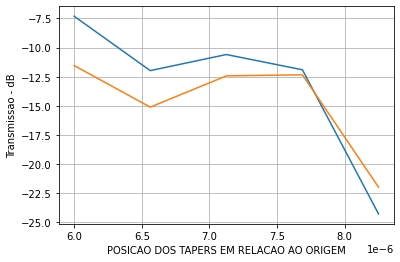

In [9]:
plt.plot(move_Matrix,dMatrix_1)
plt.xlabel("POSICAO DOS TAPERS EM RELACAO AO ORIGEM")
plt.ylabel("Transmissao - dB")
plt.grid(True)

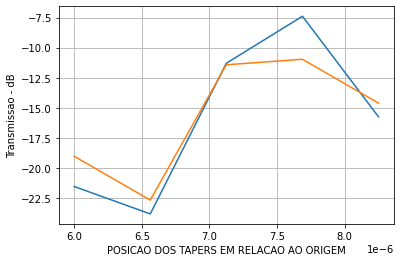

In [10]:
plt.plot(move_Matrix,dMatrix_2)
plt.xlabel("POSICAO DOS TAPERS EM RELACAO AO ORIGEM")
plt.ylabel("Transmissao - dB")
plt.grid(True)